In [69]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass

from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [70]:
PATH = 'train_df.csv'

In [71]:
@dataclass
class DecisionTreeDataframe:
    df: pd.DataFrame
    label: str
    n_splits: int = 10
    n_repeats: int = 3
    random_state: int = 0
    n_jobs: int = -1
    scoring: str = 'f1_weighted'

    def get_class_weight(self) -> dict:
        label_size = self.df[self.label].value_counts(normalize=True)[1]*100
        return {0: label_size, 1: 100}
    
    def get_number_of_features(self) -> list:
        return list(range(2, len(self.df.columns)))
    
    def get_number_of_nodes(self) -> list:
        return list(range(3, 9))
    
    def get_tree_depth(self) -> list:
        return list(range(1, 6))
    
    def get_param_grid(self) -> dict:
        return dict(
            max_leaf_nodes = self.get_number_of_nodes(),
            max_depth = self.get_tree_depth(),
            max_features = self.get_number_of_features()
        )

    def get_train_test(self) -> list:
        X = self.df.drop(self.label, axis=1)
        y = self.df[self.label]
        return X, y
    
    def get_train_test_split(self) -> list:
        X, y = self.get_train_test()
        return train_test_split(X, y, random_state=0)    

In [72]:
def get_origin_dataset(path) -> pd.DataFrame:
    return pd.read_csv(path)


def get_generic_decision_tree(DtDf: DecisionTreeDataframe) -> DecisionTreeClassifier:
    return DecisionTreeClassifier(
        random_state = 0, class_weight = DtDf.get_class_weight()
    )


def get_tuned_decision_tree(
    DtDf: DecisionTreeDataframe,
    best_max_leaf_nodes: int,
    best_max_depth: int,
    best_max_features: int
) -> DecisionTreeClassifier:
    return DecisionTreeClassifier(
        random_state = 0,
        class_weight = DtDf.get_class_weight(), 
        max_leaf_nodes = best_max_leaf_nodes,
        max_depth = best_max_depth,
        max_features = best_max_features
    )


def get_generic_kfold(n_splits: int, n_repeats: int, random_state:int) -> RepeatedStratifiedKFold:
    return RepeatedStratifiedKFold(
        n_splits = n_splits, n_repeats = n_repeats, random_state = random_state
    )


def get_gridsearchcv(DtDf: DecisionTreeDataframe) -> GridSearchCV:
    return GridSearchCV(
        estimator = get_generic_decision_tree(DtDf), 
        param_grid = DtDf.get_param_grid(), 
        n_jobs = DtDf.n_jobs, 
        cv=get_generic_kfold(
            n_splits = DtDf.n_splits, 
            n_repeats = DtDf.n_repeats, 
            random_state = DtDf.random_state
        ), 
        scoring = DtDf.scoring
    )


def get_tree_plot(clf_dt: DecisionTreeClassifier, class_names: list, X: pd.DataFrame) -> None:
    plt.figure(figsize=(30,15))
    plot_tree(
        clf_dt,
        filled=True,
        rounded=True,
        class_names=class_names,
        feature_names=X.columns
    )
    return plt.show()

In [73]:
def main():
    df = get_origin_dataset(PATH)

    DtDf = DecisionTreeDataframe(
        df = df,
        label = "fraud"
    )

    X, y = DtDf.get_train_test()

    grid_result = get_gridsearchcv(DtDf).fit(X, y)
    
    print(f"Best {grid_result.scoring}: {grid_result.best_score_} using {grid_result.best_params_}")

    best_max_leaf_nodes = grid_result.best_params_['max_leaf_nodes']
    best_max_depth = grid_result.best_params_['max_depth']
    best_max_features = grid_result.best_params_['max_features']

    clf_dt = get_tuned_decision_tree(
        DtDf, 
        best_max_leaf_nodes,
        best_max_depth,
        best_max_features
    )

    clf_dt = clf_dt.fit(X, y)
    
    df_fi = pd.DataFrame(data={'feature_name': clf_dt.feature_names_in_.tolist(),
                           'importance': clf_dt.feature_importances_.tolist()})
    
    return get_tree_plot(clf_dt, ['No Fraud', 'Yes Fraud'], X)

Best f1_weighted: 0.8955415903588843 using {'max_depth': 4, 'max_features': 3, 'max_leaf_nodes': 8}


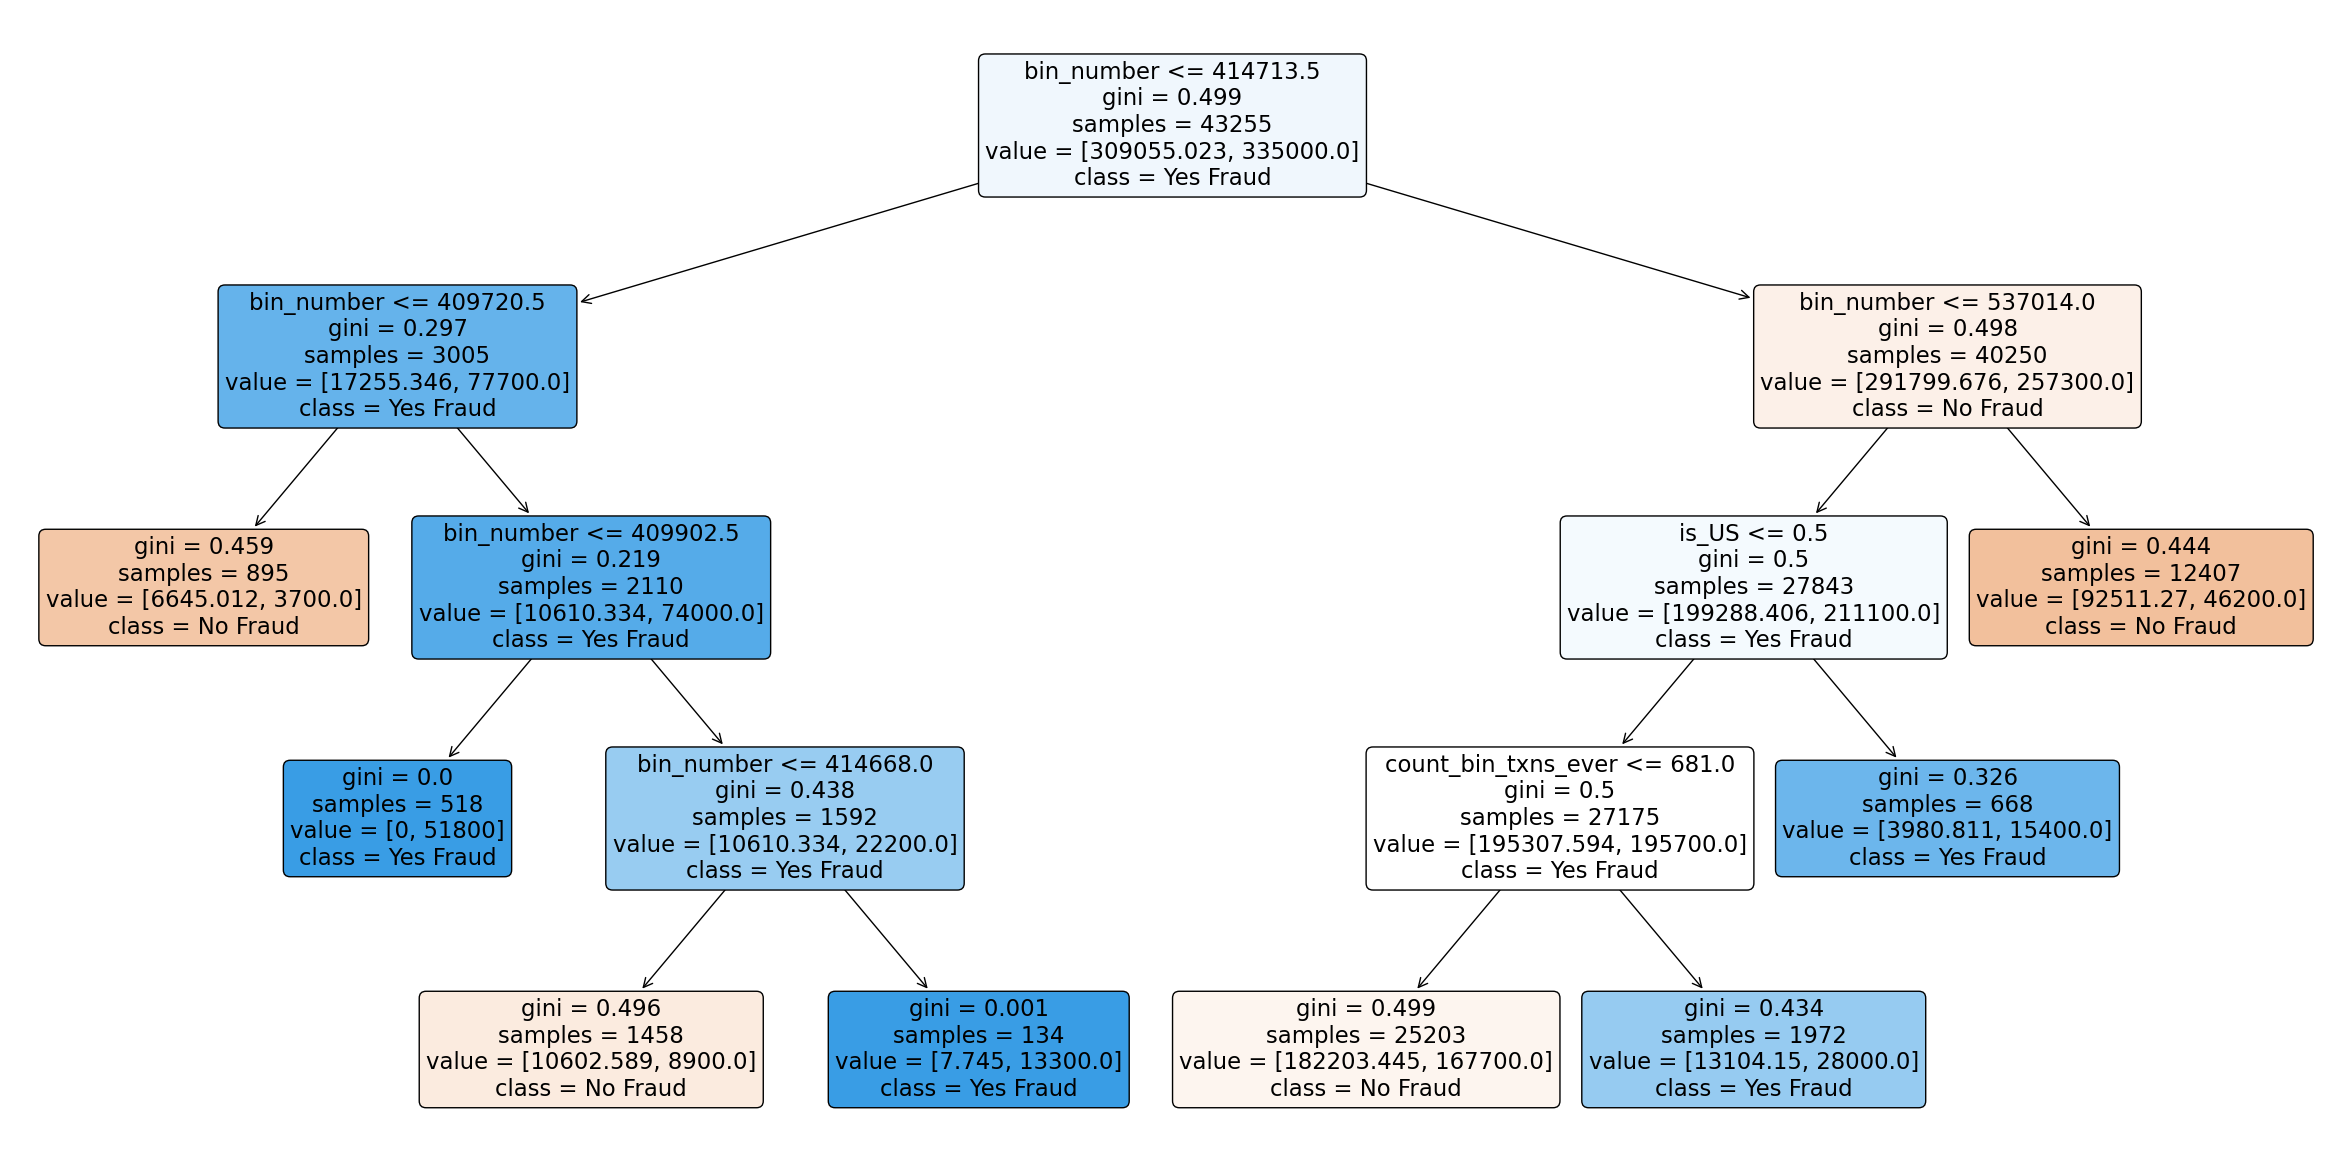

In [74]:
main()

## Generic Decision Tree Performance

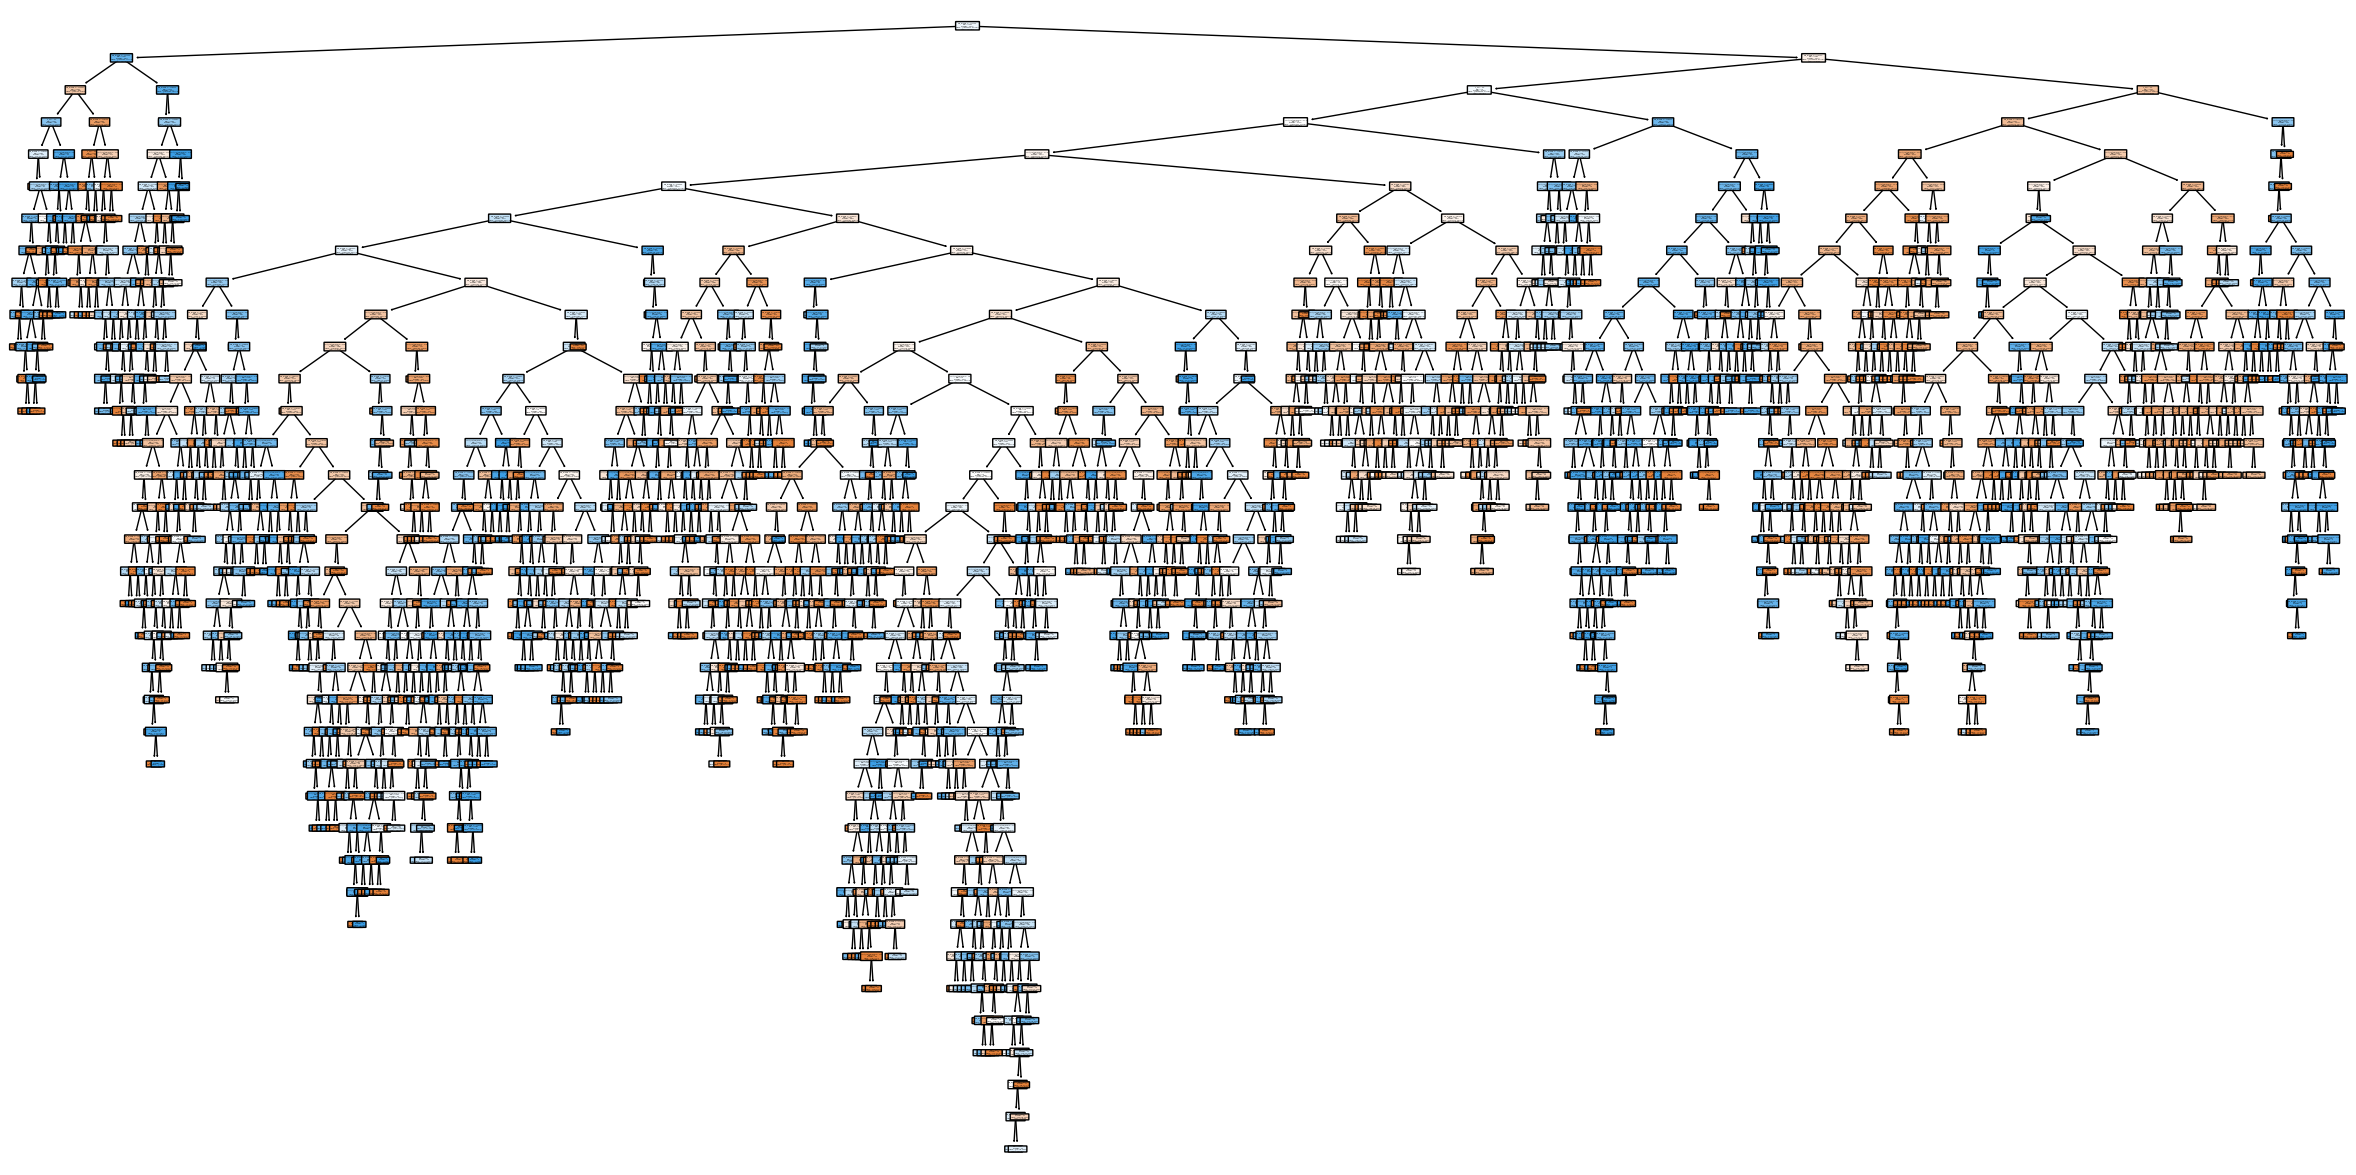

In [75]:
df = get_origin_dataset(PATH)

DtDf = DecisionTreeDataframe(
    df = df,
    label = "fraud"
)

X, y = DtDf.get_train_test()

clf_dt = get_generic_decision_tree(DtDf)

_clf_dt = clf_dt.fit(X, y)

get_tree_plot(_clf_dt, ['No Fraud', 'Yes Fraud'], X)

In [76]:
df_test = get_origin_dataset("test_df.csv")

X_test = df_test.drop('fraud', axis=1).copy()
y_test = df_test['fraud'].copy()

y_pred = clf_dt.predict(X_test)

print("Accuracy:    ",metrics.accuracy_score(y_test, y_pred))
print("F1-weighted: ",metrics.f1_score(y_test, y_pred, average='weighted'))
print("Recall:      ",metrics.recall_score(y_test, y_pred))
print("Precision:   ",metrics.precision_score(y_test, y_pred))

Accuracy:     0.7729640996360003
F1-weighted:  0.821804324203025
Recall:       0.5456329735034348
Precision:    0.16982284667073916


## Cost Complexity Prunning

In [77]:
path = clf_dt.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [78]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

In [79]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

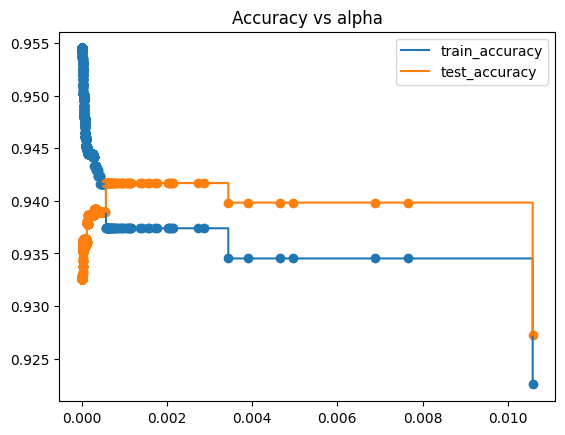

In [80]:
from sklearn.metrics import accuracy_score,confusion_matrix

train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [81]:
df_alphas = pd.DataFrame(
    data={
        "alphas": [round(x,4) for x in list(ccp_alphas)],
        "train_acc": train_acc,
        "test_acc": test_acc
    }
)

df_alphas["opt_alpha"] = df_alphas.test_acc > df_alphas.train_acc

optmz_alpha = min(df_alphas.query("opt_alpha == True").alphas)

In [82]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=optmz_alpha)
clf_.fit(X,y)
y_train_pred = clf_.predict(X)
y_test_pred = clf_.predict(X_test)

print("Accuracy:    ",metrics.accuracy_score(y_test, y_test_pred))
print("F1-weighted: ",metrics.f1_score(y_test, y_test_pred, average='weighted'))
print("Recall:      ",metrics.recall_score(y_test, y_test_pred))
print("Precision:   ",metrics.precision_score(y_test, y_test_pred))

Accuracy:     0.9416886731853543
F1-weighted:  0.9233770420554297
Recall:       0.20215897939156036
Precision:    0.9809523809523809


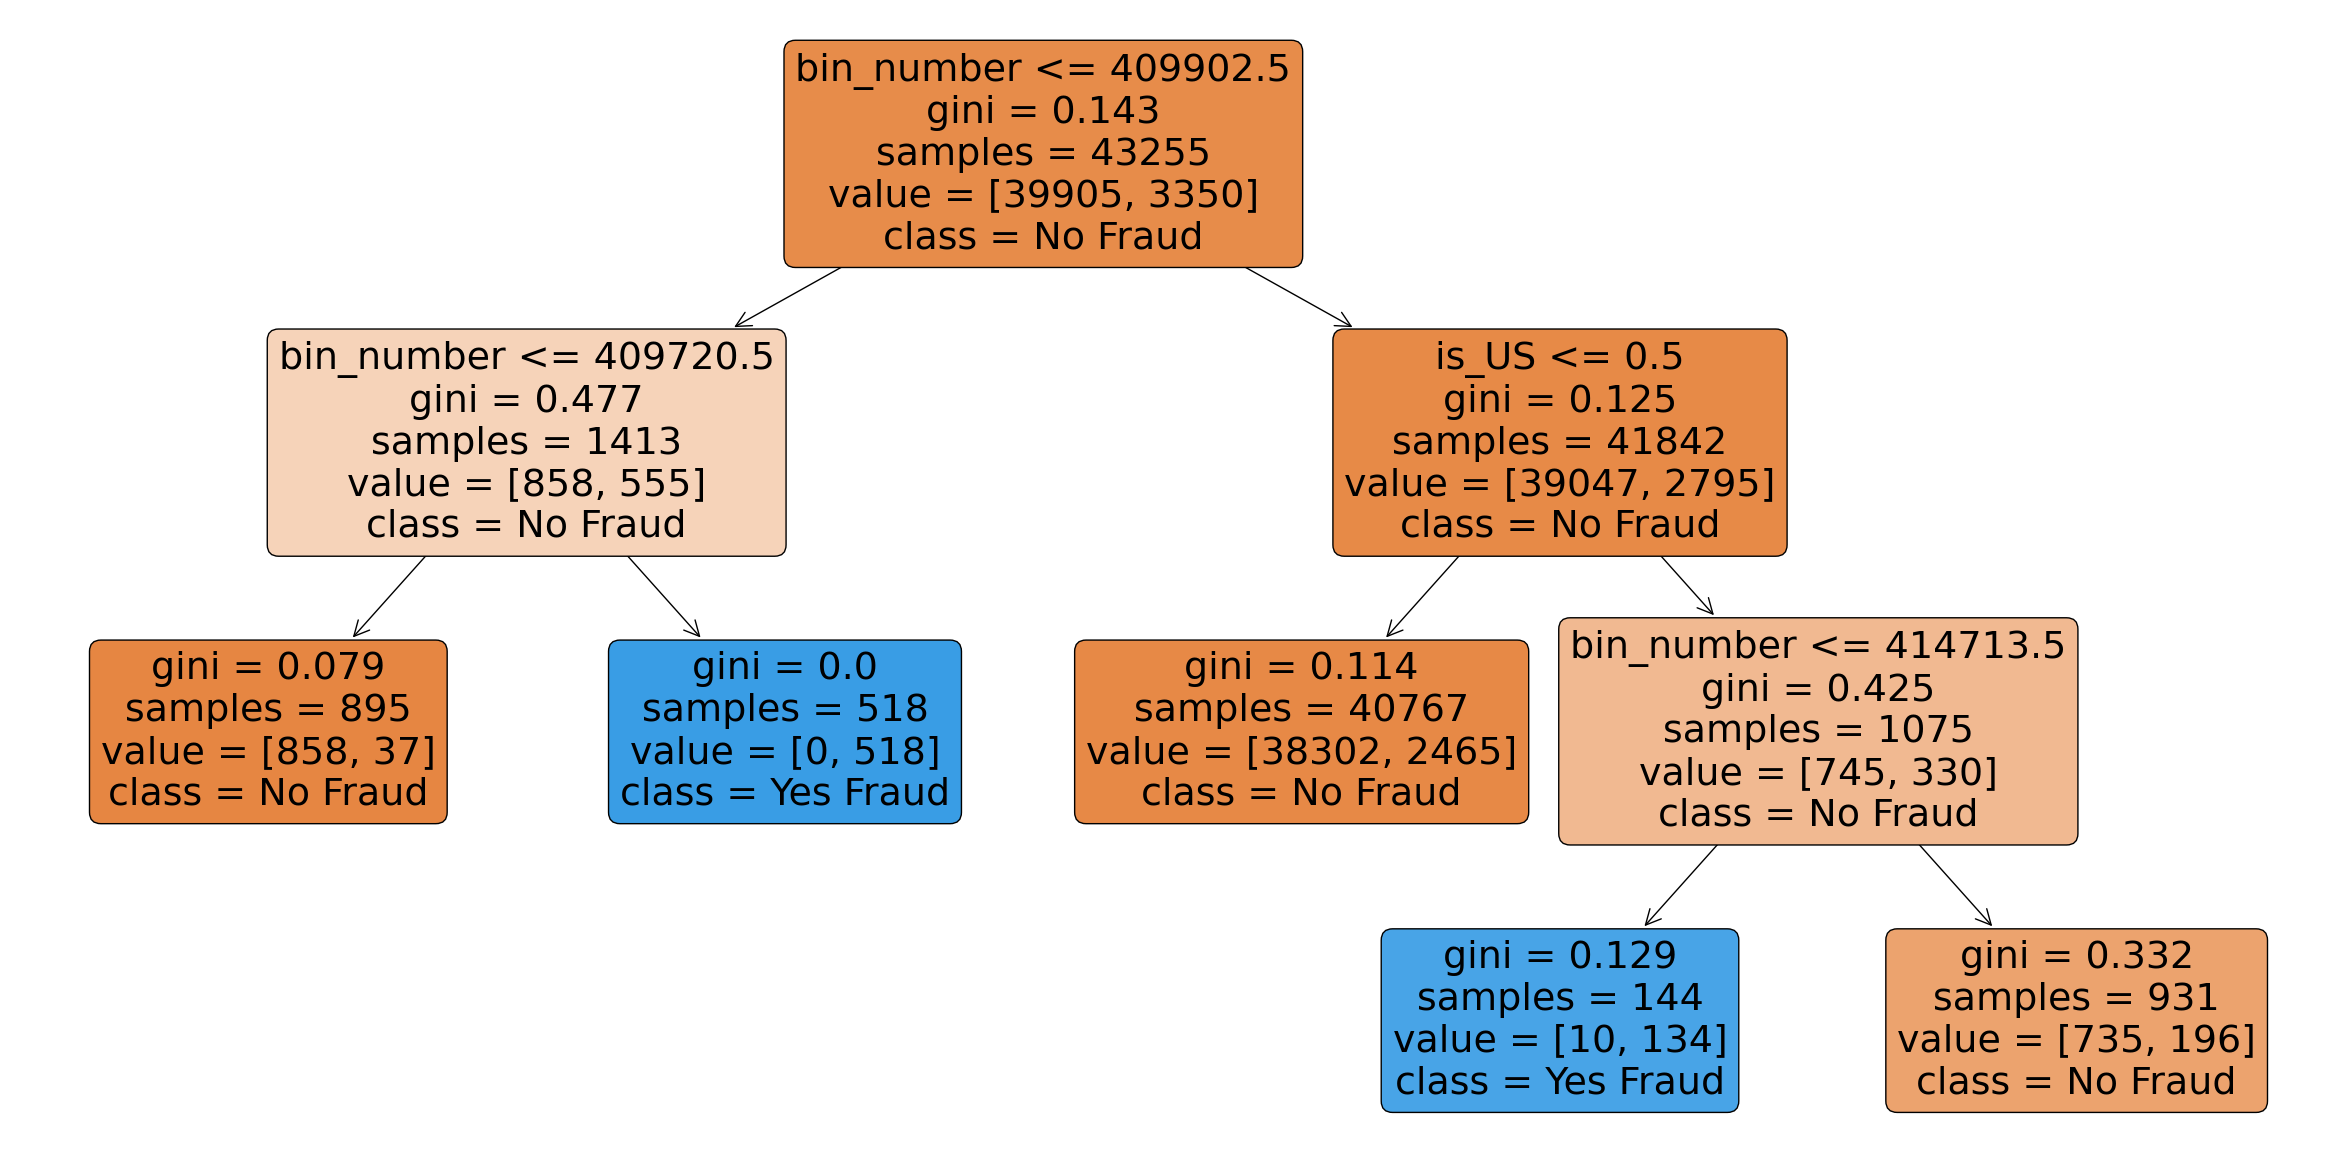

In [83]:
get_tree_plot(clf_, ['No Fraud', 'Yes Fraud'], X)